# Maximum Likelihood
Reference: SomeDerivations181007.pdf, Volatility180917.pdf

## Content:

* (1) [The Delta Method](#section1)
* (2.1) [Maximizing the likelihood of a Normal](#section21)
* (2.2) [Computing Cov($\theta$)](#section22)
* (3) [MA(1)](#section3)
* (4) [GARCH(1, 1)](#section4)

-----------------

<a id='section1'></a>
## (1) The Delta Method

In [1]:
using Distributions: Normal
using Statistics: mean, var
using Random
using ForwardDiff

Random.seed!(123)

returns = rand(Normal(0.3, 1), 10000)
μ = mean(returns)
σ² = var(returns, corrected=false)

# Analytical Sharpe ratio standard errors
R = μ / sqrt(σ²)
δR = [1 / sqrt(σ²) -0.5 * μ / sqrt(σ²)^3]
V₀ = [σ² 0 ;
      0  2*σ²^2]

sqrt(δR * V₀ * δR')

1×1 Array{Float64,2}:
 1.023618652418126

In [2]:
# The exact ones
sqrt(1 + 0.3^2 / 2)

1.0222524150130436

In [3]:
# Numerical gradient:
# For an example of using ForwardDiff with a function
# that allocates storage: see the MA(1) example
function Rfunction(θ::Array)
    μ = θ[1]
    σ² = θ[2]

    μ / sqrt(σ²)
end

θhat = [μ σ²]
g = ForwardDiff.gradient(Rfunction, θhat)

# Gives standard erros:
sqrt(g * V₀ * g')

1×1 Array{Float64,2}:
 1.023618652418126

<a id='section21'></a>
## (2.1) Maximizing the likelihood of a Normal

In [4]:
using LinearAlgebra: inv, diag
using Optim: optimize, BFGS
using Distributions: Normal
using Statistics: mean, var
using Random
using ForwardDiff

Random.seed!(123)

"""
A Julia function declaration, giving the log likelihood of each observation.
The `::` arguments are optional type declarations (in Julia, a vector
is just an alias for a flat array).

The `.` before some operators or functions means broadcast this to all elements
of an array.

x::Union{Array, Number} means L_t can compute the score at a single
observation, or the entire data array, returning a scalar or an array
respectively. 
"""
function L_t(θ::Array, x::Union{Array, Number})
    μ = θ[1]
    σ² = θ[2]
    if σ² <= 0 return Inf end

    -1/2 * log(2 * π * σ²) .- 1/2 * (x .- μ).^2 / σ²
end

function L_T(θ::Array, x::Array)
    mean(L_t(θ, x))
end

L_T (generic function with 1 method)

In [5]:
# Generate data
data = rand(Normal(1.5, 1), 100)

# Maximize the average log likelihood, with starting values [1 1],
# with `BFGS` as the solver.
# The construct `θ ->` constructs an anonymous function, it tells
# optim to the maxmize `L_T` as a function of θ, with `x` fixed.
# Since `optimize` minimizes, we pass on the negative
# of L_T to maximise. 
res = optimize(θ -> -L_T(θ, data), ones(2), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0]
 * Minimizer: [1.53669207719603,1.2607427545544763]
 * Minimum: 1.534789e+00
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.40e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 5.35e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.45e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 13
 * Gradient Calls: 13

In [6]:
# The ML estimates
μ = res.minimizer[1]
σ² = res.minimizer[2]

1.2607427545544763

Which of course should be the same as

In [7]:
mean(data), var(data, corrected=false)

(1.5366920772016885, 1.2607427545736334)

<a id='section22'></a>
## (2.2) Computing Cov($\theta$)

In [8]:
T = length(data)
# The sample mean of the hessians is the same as the 
# hession of the sample mean (because θ does not depend on t):
I = - ForwardDiff.hessian(θ -> L_T(θ, data), res.minimizer)

2×2 Array{Float64,2}:
 0.793183    3.5601e-12
 3.5601e-12  0.31457   

In [9]:
# (map computes the function (hessian) at each data point)
I_alt = - mean(map(x -> 
                    ForwardDiff.hessian(θ -> L_t(θ, x), res.minimizer),
                    data)
)

I == I_alt

true

In [10]:
# Enforcing symmetry
I = (I + I') / 2

# The sample average of the outer product of the score:
G = ForwardDiff.jacobian(z -> L_t(z, data), res.minimizer)
J = G' * G / T

2×2 Array{Float64,2}:
  0.793183   -0.0353099
 -0.0353099   0.384995 

The 3 different variance-covariance estimates

In [11]:
# se1
vcv1 = inv(I) / T
sqrt.(diag(vcv1))

2-element Array{Float64,1}:
 0.11228280164631076
 0.1782959502127462 

In [12]:
# se2
vcv2 = inv(J) / T
sqrt.(diag(vcv2))

2-element Array{Float64,1}:
 0.11251272376487367
 0.1614957425900758 

In [13]:
# se3
vcv3 = inv(I) * J * inv(I) / T
sqrt.(diag(vcv3))

2-element Array{Float64,1}:
 0.11228280164722043
 0.19724694148004998

--------------------

<a id='section3'></a>
## (3) MA(1)

Simulate an MA(1)

$y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}$

And estimate it with the conditional likelihood (i.e. given $\epsilon_0 = 0$) 

(Reference: Hamilton ch 5.4 p.127)

In [1]:
using Distributions: Normal, logpdf
using Statistics: mean
using Optim: optimize, BFGS
using Random

Random.seed!(123)

# Simulate the MA(1)
T = 1000
θ₁ = 0.1
μ = 1.5
σ² = 1.9
ϵ = rand(Normal(0, sqrt(σ²)), T)
y = zeros(T)
for t in 2:T
    y[t] = μ + ϵ[t] + θ₁ * ϵ[t-1]
end

# The conditional likelihood for each observation
function L_t(θ::Array, x::Array)
    T = length(x)
    μ = θ[1]
    θ₁ = θ[2]
    σ² = θ[3]
    if σ² <0 return Inf end 
    # Why `eltype`: With temporary storage allocated
    # inside a function, ForwardDiff needs an explicit type
    # declaration
    ϵ = zeros(eltype(θ), T)
    ϵ[1] = x[1] - μ 
    
    for t in 2:T
        ϵ[t] = x[t] - μ - θ₁ * ϵ[t-1]
    end
    
    # The pdf of every x_t is N(μ + θϵ_t, σ²)
    # Instead of writing down the simple normal likelihood algebra,
    # we can just use the Julia generic logpdf function
    logpdf.(Normal.(-(ϵ-x), sqrt(σ²)), x)
end

function L_T(θ::Array, x::Array)
    mean(L_t(θ, x))
end

L_T (generic function with 1 method)

Maximize the likelihood as before

In [2]:
res = optimize(θ -> -L_T(θ, y), ones(3), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0,1.0]
 * Minimizer: [1.5357122438059683,0.12888640802855023, ...]
 * Minimum: 1.747966e+00
 * Iterations: 14
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.02e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 5.53e-13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.26e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 51
 * Gradient Calls: 51

In [3]:
# Which is very close
res.minimizer

3-element Array{Float64,1}:
 1.5357122438059683 
 0.12888640802855023
 1.9310342650975323 

-----------------------

<a id='section4'></a>
##   (4)  GARCH(1, 1)

In [17]:
using LinearAlgebra: inv, diag, Diagonal
using Optim: optimize, BFGS
using Distributions: Normal, logpdf
using Statistics: var, mean
using Plots: plot
using ForwardDiff
using Random

"""
The log likelihood for each observation of a GARCH(1, 1), with
non-negativity enforced by the transformation θ^2
"""
function L_t(θ::Array, R::Array)
    μ = θ[1]
    α₀ = θ[2]^2
    α₁ = θ[3]^2
    β = θ[4]^2
    T = length(R)

    ε = R .- μ
    σ² = zeros(typeof(α₀), T) 
    σ²[1] = α₀ + α₁* var(R, corrected=false) + β * var(R, corrected=false)
    # Alternative: σ²[1] = α₀ + α₁* 0 + β * var(R) 
  
    for t=2:T
      σ²[t] = α₀ + α₁ * ε[t-1] ^ 2 + β * σ²[t-1]
    end
    
    logpdf.(Normal.(μ, sqrt.(σ²)), R)
end

function L_T(θ::Array, x::Array)
    mean(L_t(θ, x))
end

L_T (generic function with 1 method)

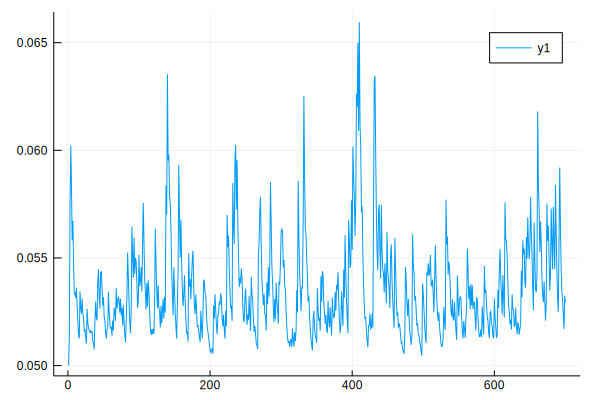

In [18]:
# Simulating a GARCH(1, 1)
Random.seed!(3)
T = 700
e = randn(T)
u = ones(T)
R = zeros(T)
sigma2 = fill(0.05, T) # 0.05: The unconditional variance
for t=1:(T-1)
    u[t] = e[t] * sqrt(sigma2[t])
    sigma2[t+1] = 0.015 + 0.02 * u[t]^2 + 0.7 * sigma2[t]
    R[t+1] = 0.3 + u[t]
end

plot(sigma2)

In [19]:
# Maximize the log likelihood
res = optimize(θ -> -L_T(θ, R), [0.5 0.05 0.05 0.5], BFGS())
θhat = res.minimizer
coefs = [θhat[1] θhat[2]^2 θhat[3]^2 θhat[4]^2]
# Should be ~ [0.3 0.015 0.02 0.7]

1×4 Array{Float64,2}:
 0.303744  0.00919995  0.0497936  0.775263

In [20]:
# Standard errors with the Delta method
I = - ForwardDiff.hessian(θ -> L_T(θ, R), res.minimizer);
I = (I + I') / 2

G = ForwardDiff.jacobian(θ -> L_t(θ, R), res.minimizer);
J = G' * G / T

h = Diagonal([1, 2*θhat[2], 2*θhat[3], 2*θhat[4]])

4×4 Diagonal{Float64,Array{Float64,1}}:
 1.0    ⋅          ⋅        ⋅     
  ⋅   -0.191833    ⋅        ⋅     
  ⋅     ⋅        -0.44629   ⋅     
  ⋅     ⋅          ⋅       1.76098

In [21]:
# se1
vcv1 = h * inv(I) * h' / T
sqrt.(diag(vcv1))

4-element Array{Float64,1}:
 0.008709850580142666
 0.007379152785994987
 0.030378694318415642
 0.15784390655161396 

In [22]:
# se (Q-MLE)
vcv2 = h * inv(I) * J * inv(I) * h' / T
sqrt.(diag(vcv2))

4-element Array{Float64,1}:
 0.008799795767776872 
 0.0058372832472049635
 0.027752699553038232 
 0.12402738336934056  